# Visualizing Ellen White's Plagerism Using a Trained Convolutional Neural Network Model and Heatmaps

## Introduction
Ellen G. White (1827 – 1915) was an American author and co-founder of the Seventh-day Adventist church. She published about 155 books, about 5,000 periodical articles, and 200 pamphlets. The White Estate has made much of her written material available to [read online for free](https://egwwritings.org/).

It is well known that some of her material was borrowed from other authors, and that some of that borrowed material was not  credited to the original authors. Instances of this have been documented by others such as Walter Rae in his book _The White Lie_, and more recently in a [video series by youtuber "Test the Prophet"](https://www.youtube.com/@TesttheProphet/videos). More details on the criticisms and their rebuttals can be found in this [wikipedia article](https://en.wikipedia.org/wiki/Inspiration_of_Ellen_G._White#Sources_and_plagiarism_charges). The White Estate ....

Here, we demonstrate three approaches for detecting plagerized text using a convulutional neural network model. For the second and throd approach, we use a heatmap to display the results.

## Methodology
### Data
Ellen White's book _Sketches from the Life of Paul_, Chapter XXVII, Caesar’s Household, is known to contain text that is based on _Sermons_, Sermon V, Caeser's Household, by Henry Melvill (1798 – 1871), a British priest in the Church of England.

Original copies of these books were not purchased for this demonstration, but scans of each book are available from Google Books:
- [Sermons](https://www.google.com/books/edition/Sermons/RDkPAAAAYAAJ?hl=en&gbpv=1&pg=PA468&printsec=frontcover&bksoutput=text)
- [Skethces from the Life of Paul](https://www.google.com/books/edition/Sketches_from_the_Life_of_Paul/8_s2AAAAMAAJ?hl=en&gbpv=1&pg=PA293&printsec=frontcover&bksoutput=text)

The [Google Books API](https://developers.google.com/books) does not provide a method for programmatically extracting text, but the scanned images allow for the text to be manually copied from the images and pasted into text documents using the usual commands `cmd/ctrl-c` and `cmd/ctrl-v`. The files containing the pasted text are located in the `data` folder.

### Tools
We use the [Python](https://www.python.org/) programming language together with various libraries. The heavy lifting is handled by the [spaCy](https://spacy.io/), an open-source software library for advanced natural language processing.

spaCy contains features for parsing text into ... and methods for comparing sets of text 

## Experiment

Import the neccessary libraries.

In [34]:
import seaborn as sns
import spacy
import numpy
import textwrap

# load the CNN model
nlp = spacy.load("en_core_web_lg")

### Loading the data
Loading the data is a straightforward process: open the file, then use spaCy to process the text.

In [2]:
# open the file containing White's text
egw = open("data/egw.txt", "r")
# process White's text
doc_egw = nlp(egw.read())
assert doc_egw.has_annotation("SENT_START")
egw.close()

# open the file containing Melvill's text
mel = open("data/melvill.txt", "r")
# process Melvill's text
doc_mel = nlp(mel.read())
assert doc_mel.has_annotation("SENT_START")
mel.close()

### Cleaning the data
Text typically needs to be "cleaned" before it is suitable for consumption by natural language processing libraries. There is no easy way to know beforehand what type of cleaning is needed; the text needs to be examined beforehand. 

Fortunately spaCy does some of this cleaning for us, but we should additionally check for words that are not supported by the CNN model. We can use the data already processed by the model to do so:

In [3]:
# Get the unsupported words from White's text
u = [x.text for x in doc_egw if x.is_alpha and not x.has_vector]

# Get the unsupported words from Melvill's text
v = [x.text for x in doc_mel if x.is_alpha and not x.has_vector]

# Print all unsupported words with the duplicates removed.
print('\n'.join(set(u + v)))

Nazarine
conciliates
blamelessness
prayerfulness
appertained
slothfulness
viler
setteth
advantageousness
devotedness
recompences
Cæsars
whensoever
obligingness
exigence
discountenanced
efficaciousness
apostolical
hinderances
circumstanced
drudgeries
debauchee
withdrawment


We can try to replace these unsupported words with suitable synonymns or alternate spellings that do not change the meaning of the original text. There are Python libraries that could be used to automate this process, but for our data, the set of unsupported words is small so manually finding suitable synonyms is not overly time consuming.

To further aid us, we use spaCy to locate the sentences containing each unsupported word, then print them out. In some cases, there are extra whitespace characters left over from parsing the text files, but these will be ignored during text comparison.

In [18]:
# For each unsupported word, print its containing sentence.
u_sentences = [x.sent.text.trim() for x in doc_egw if x.is_alpha and not x.has_vector]
v_sentences = [x.sent.text.trim() for x in doc_mel if x.is_alpha and not x.has_vector]
print('\n\n'.join(set(u_sentences + v_sentences)))

With all this information, we create a list replacement words or phrases and use it to create cleaned versions of the original data files.

In [5]:
# Create a dictionary of words and their replacements
replace_words = {
    "Nazarine": "Nazarene",
    "slothfulness": "laziness",
    "viler": "fouler",
    "Cæsar": "Caesar",
    "appertained": "applied",
    "debauchee": "hedonist",
    "efficaciousness": "effectiveness",
    "exigence": "urgency",
    "advantageousness": "usefulness",
    "setteth": "set",
    "whensoever": "whenever",
    "withdrawment": "withdrawal",
    "recompences": "recompenses",
    "blamelessness": "purity",
    "discountenanced": "confused",
    "conciliates": "wins over",
    "obligingness": "willingness",
    "prayerfulness": "devoutness",
    "hinderances": "hindrances",
    "apostolical": "apostolic",
    "drudgeries": "toils",
    "devotedness": "fervour",
    "circumstanced": "situated"
}

# Replace the unsuuported words, writing the cleaned output into new files.
# Each tupple in the list contains the filename of the original file
# followed by the filename of the cleaned version of the original file.
filename_pair = [
    ("data/egw.txt", "data/egw_cleaned.txt"),
    ("data/melvill.txt", "data/melvill_cleaned.txt")
]

for orig, clean in filename_pair:
    orig_file = open(orig, "r")
    clean_file = open(clean, "w")
    for line in orig_file:
        for k, v in replace_words.items():
            line = line.replace(k, v)
        clean_file.write(line)
    orig_file.close()
    clean_file.close()

We must load the cleaned files into spaCy to use the updated data. A simple check reveals that every word of the processed data is supported by the CNN.

In [6]:
# load the text
egw = open("data/egw_cleaned.txt", "r")
doc_egw = nlp(egw.read())
egw.close()

mel = open("data/melvill_cleaned.txt", "r")
doc_mel = nlp(mel.read())
mel.close()

# check for unsupported words again
u = [x.text for x in doc_egw if x.is_alpha and not x.has_vector]
v = [x.text for x in doc_mel if x.is_alpha and not x.has_vector]
print(len(set(u+v)))

0


## Analysis
Now that our data is cleaned we can explore different methods of exploring the similarity of the two textx.
### First approach: compare documents in their entirety
Each document is first tokenized. Then for each document, the average vector of all vectorizable tokens is computed. The similarity of the two documents simply a measure of the angle between the two averaged vectors. The angle is calculated using well known cosine difference equation:

$$ similarity(x, y) = \cos \theta  = \frac{x\cdot y}{\|x\|\|y\|} $$

where $x\cdot y$ is the [dot product](https://en.wikipedia.org/wiki/Dot_product) of the vectors $x, y$ and $\|x\|$ is the [Euclidean norm](https://en.wikipedia.org/wiki/Euclidean_space#Euclidean_norm) of the vector $x$. The values range from -1 to 1. A higher score indicates a smaller angle, and thus a greater similarity.

[This article](https://www.sciencedirect.com/topics/computer-science/cosine-similarity) goes into more detail on how this is used in data-mining. Note that this measure, when applied to two documents in their entirety, is not suitable for detecting plagerized text. It's suitable for finding the top search results from a body of text, when provided with search terms.

In [7]:
doc_egw.similarity(doc_mel)

0.9950467957962907

This value, although close to 1, doesn't give us much information on. It's an average measure, and it doesn't tell us which parts of the two documents are more similar to each other than others.

### Second approach: pairwise sentence comparison
Instead of comparing the documents in their entirety, we can use the precomputed averaged vectors of each sentence and compare them pairwise.

It is easy to check that similar sentences have high similarity scores. Consider the following pair of sentences, one from each document:

In [8]:
a = list(doc_egw.sents)[93]
print(a)
b = list(doc_mel.sents)[112]
print(b)
a.similarity(b)

He who is thus situated has more than a common battle to fight, if he stands forth as a witness for Christ, a candidate for Heaven.
We say again that we have great sympathy with an individual thus situated: we feel that he has more than a common battle to fight, if he stand forth as a candidate for immortality.


0.9081717133522034

By running pairwise comparison of the sentences from the two documents, we might be able to detect which, if any, sentences have been plagerized.

In [9]:
Data = []

# pairwise compare each sentence, populating the array with the scores
for i, a in enumerate(doc_egw.sents):
    Data.append([])
    
    for _, b in enumerate(doc_mel.sents):
        Data[i].append(a.similarity(b))

`Data` is a 2-dimensional array of pairwise sentence similarity scores. We use this data to generate a heatmap for visualizing the similarities.

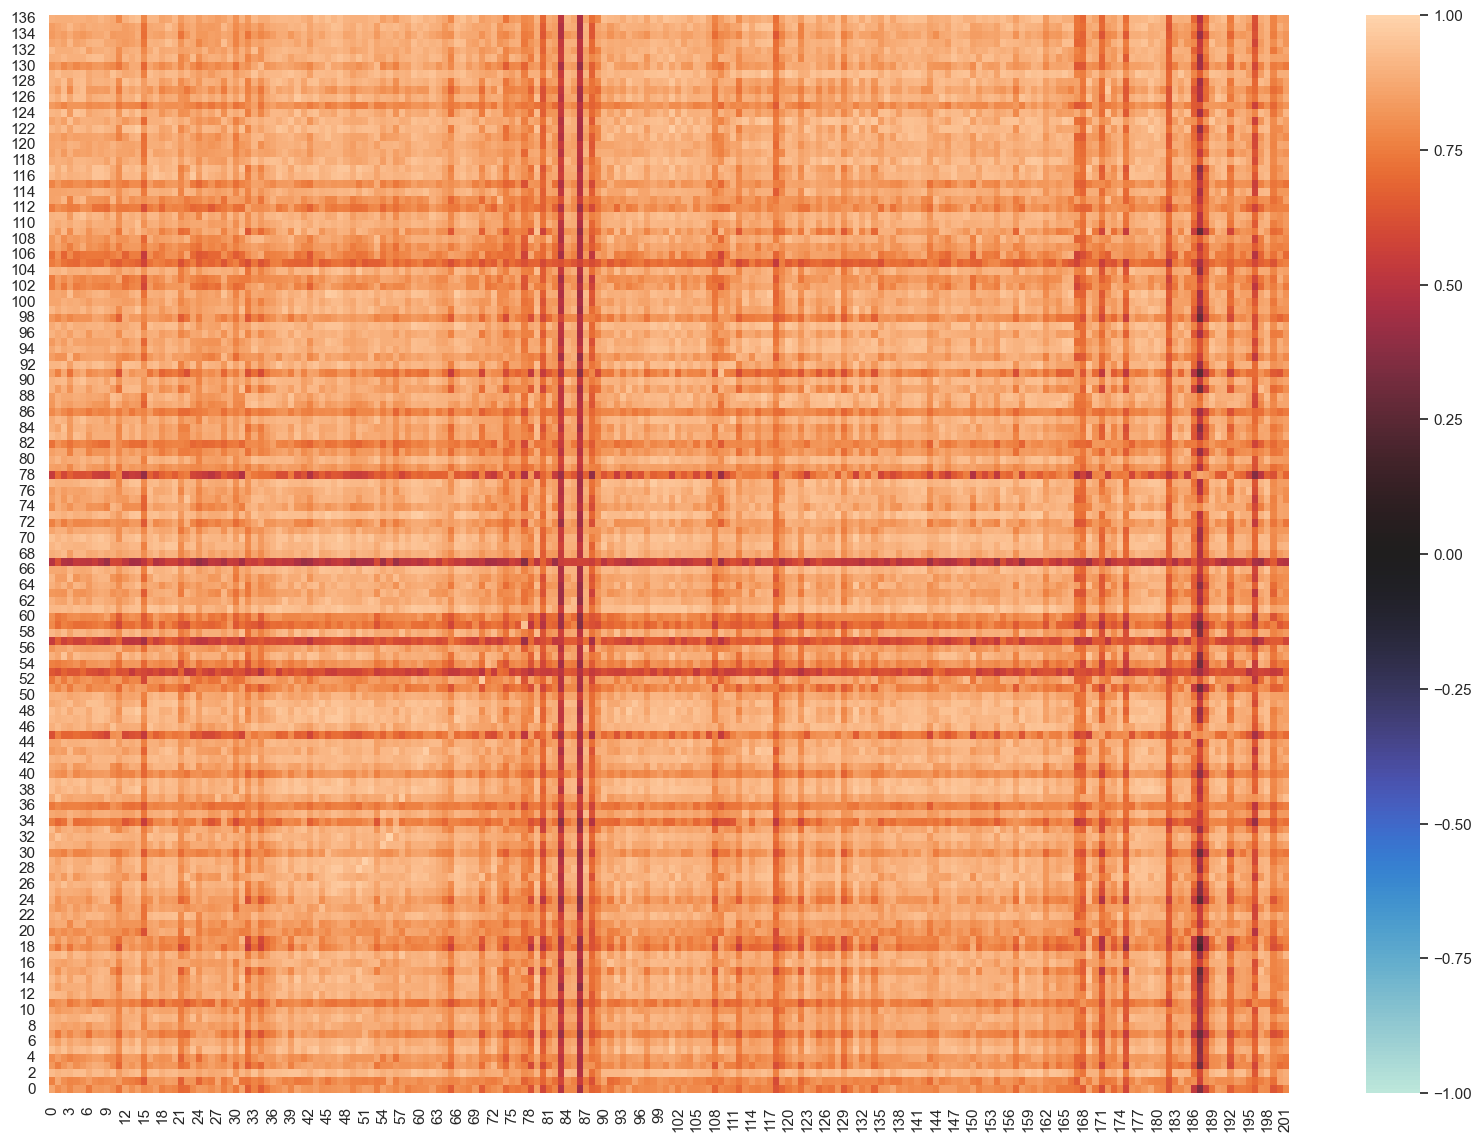

In [10]:
# create a heatmap from the data
sns.set(rc = {'figure.figsize':(20,14)})
heatmap = sns.heatmap(data=Data, vmin=-1, vmax=1, center=0)
heatmap.invert_yaxis()

In the above plot, the x-axis represents the sentences from Melvill's work, and the y-axis represents the sentences from White's text.

There is a barely perceptible lighter diagonal line in the lower left quadrant. Most of the scores already look to be greater than 0.8, making it difficult to determine which portions of the documents, if any, show signs of plagerism.

We examine the distribution of the computed similarity scores:

<AxesSubplot: ylabel='Count'>

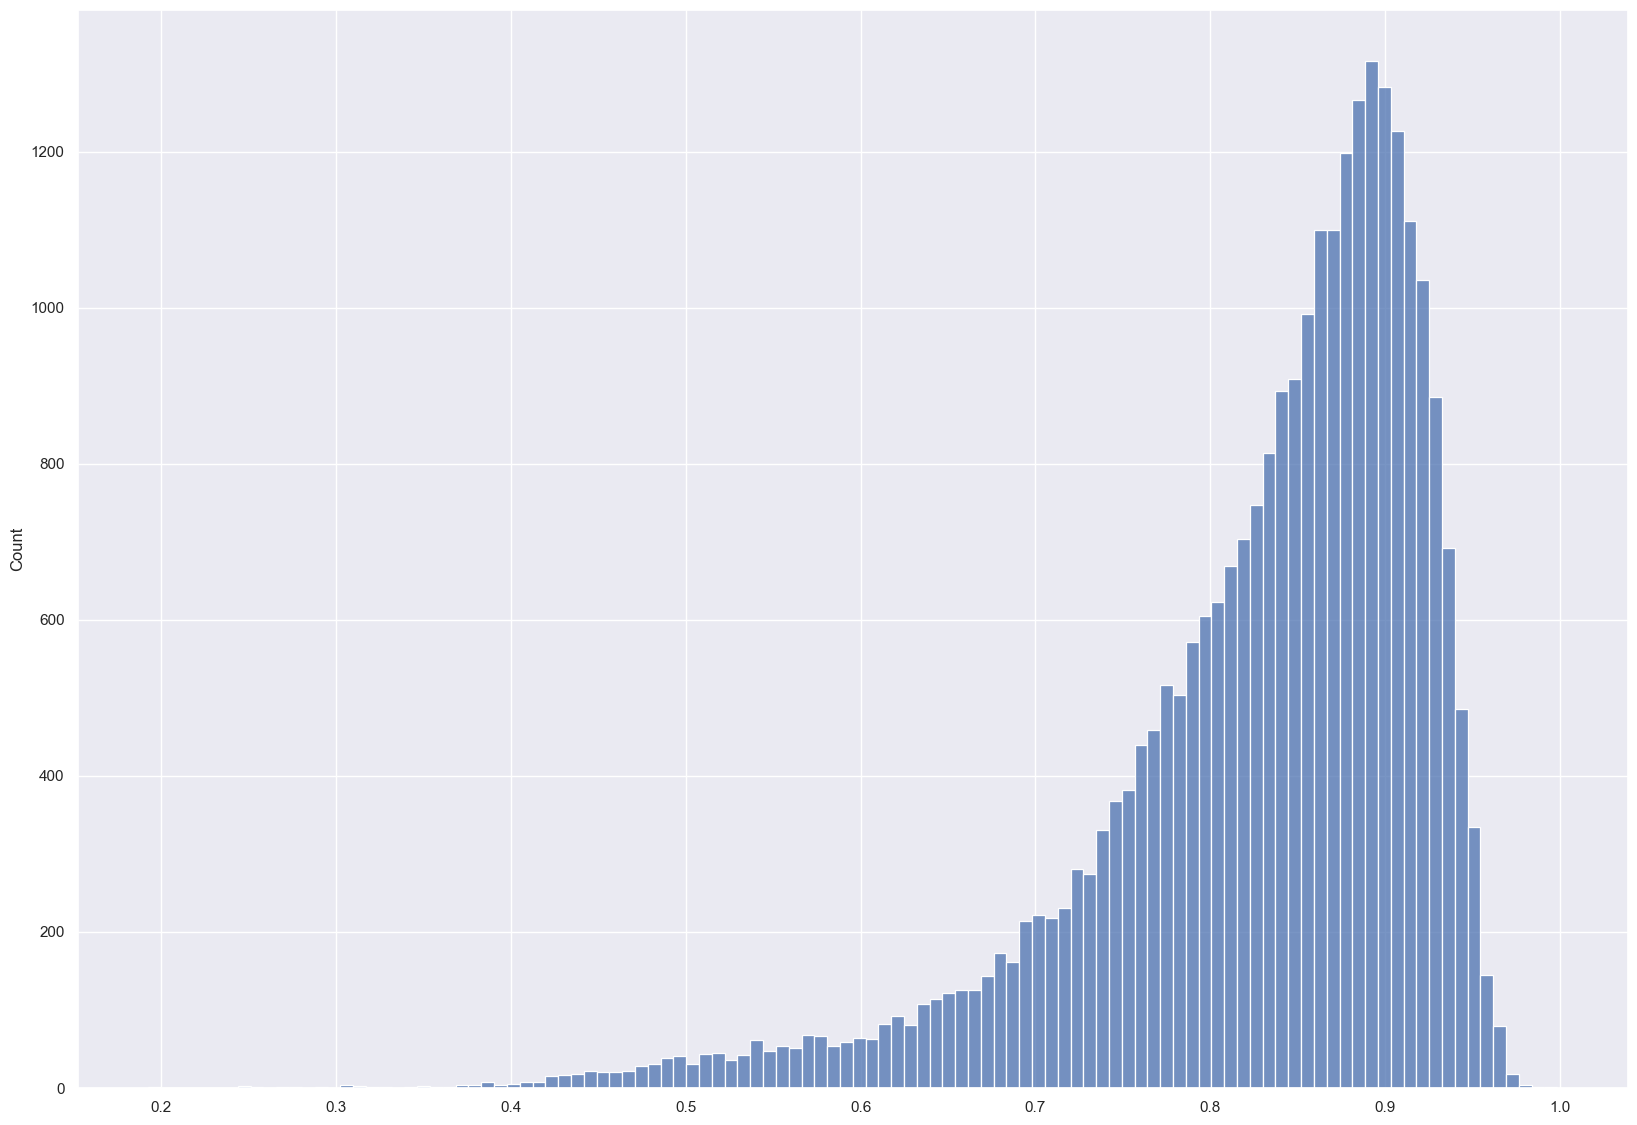

In [11]:
flat_data = [j for sub in Data for j in sub]
sns.histplot(flat_data)

Given the sizes of the original documents, we would like to see a distribution such that the number of high scoring matches is only as large as the smallest of sentences of the two documents.

### Third approach: compare the cosine similarity of individual words
This approach is taken from the sentence similarity calculator algorithm described in the "Seeding" section of [_Plagiarism Detection Using Word2vec Model_](https://www.fer.unizg.hr/_download/repository/TAR-2016-ProjectReports.pdf#page=10) (TODO: how to cite this properly?), which was itself based on an algorithm described in [_Crosslingual Plagiarism Detection with Scikit-Learn_ Dumaine](https://douglasduhaime.com/posts/crosslingual-plagiarism-detection.html) and then adapted to work with the spaCy library.

The paper has the additional pre-processing step of removing stop words. See [this article](https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a) to learn more about what stop words are, and about why we would want to remove from the text before processing. SpaCy has built-in stop word detection, and it is easy to add this into our algorithm.

This method is computationally more expensive than comparing sentences as a whole. We add a cache to reduce the time spent performing repeated comparisons of the same pair of words.

In [12]:
from spacy.tokens import Span

# A cache of similarity scores, keyed by a set containing the pair of words used to compute the score.
cache = {}

def similarity_individual_words(self, span):
    '''Use the cosine similarity of individual words, ignoring stop words, within each sentence to compute a similarity score for the two sentences'''
    count = 0
    total = 0
    
    # Iterate over all tokens in the sentence, ignoring whitespace, punctuation, numbers, stop words, etc.
    self_words = [w for w in self if w.is_alpha and not w.is_stop]
    span_words = [w for w in span if w.is_alpha and not w.is_stop]
    
    for x in self_words:
        
        max_similarity = 0
        
        for y in span_words:
            
            # Create a frozenset, which is hashable, as the key to the cache.
            # Note that we have to use the Token.text, because the tokens will
            # not be equal even when their underlying text values are equal.
            s = frozenset([x.text, y.text])
            
            # If the similarity score is already in the cache, use it.
            # Otherwise, compute the similarity score and cache it.
            if s in cache:
                similarity = cache[s]
            else:
                similarity = x.similarity(y)
                cache[s] = similarity
            
            if similarity > max_similarity:
                max_similarity = similarity
                
        if max_similarity > 0:
            count = count + 1
            total += max_similarity
    
    if count == 0:
        return 0
    
    return total/count

We use the library's [`Span.set_extension`](https://spacy.io/api/span#set_extension) class method to define our own way of computing the similarity of two sentences using the above algorithm.

In [13]:
Span.set_extension("similarity_individual_words", method=similarity_individual_words, force=True)

Next we iterate over the sentences of the two documents, using the above extention to compute the similarity scores. This takes a few minutes to complete due to the increased amount of comparisons, so there's a progress bar that tracks the progress.

In [14]:
# Progress bar
from tqdm.notebook import tqdm, trange

# Data holds the values for future plotting and examination.
Data = []

egw_sents = list(doc_egw.sents)
mel_sents = list(doc_mel.sents)

pbar = tqdm(total=(len(egw_sents) * len(mel_sents)))

# pairwise compare each sentence, populating the array with the scores
for i, a in enumerate(egw_sents):
    Data.append([])
    
    for j, b in enumerate(mel_sents):
        score = a._.similarity_individual_words(b)
        Data[i].append(score)

        pbar.update(1)

pbar.close()

  0%|          | 0/27674 [00:00<?, ?it/s]

Check the distribution of the data.

<AxesSubplot: ylabel='Count'>

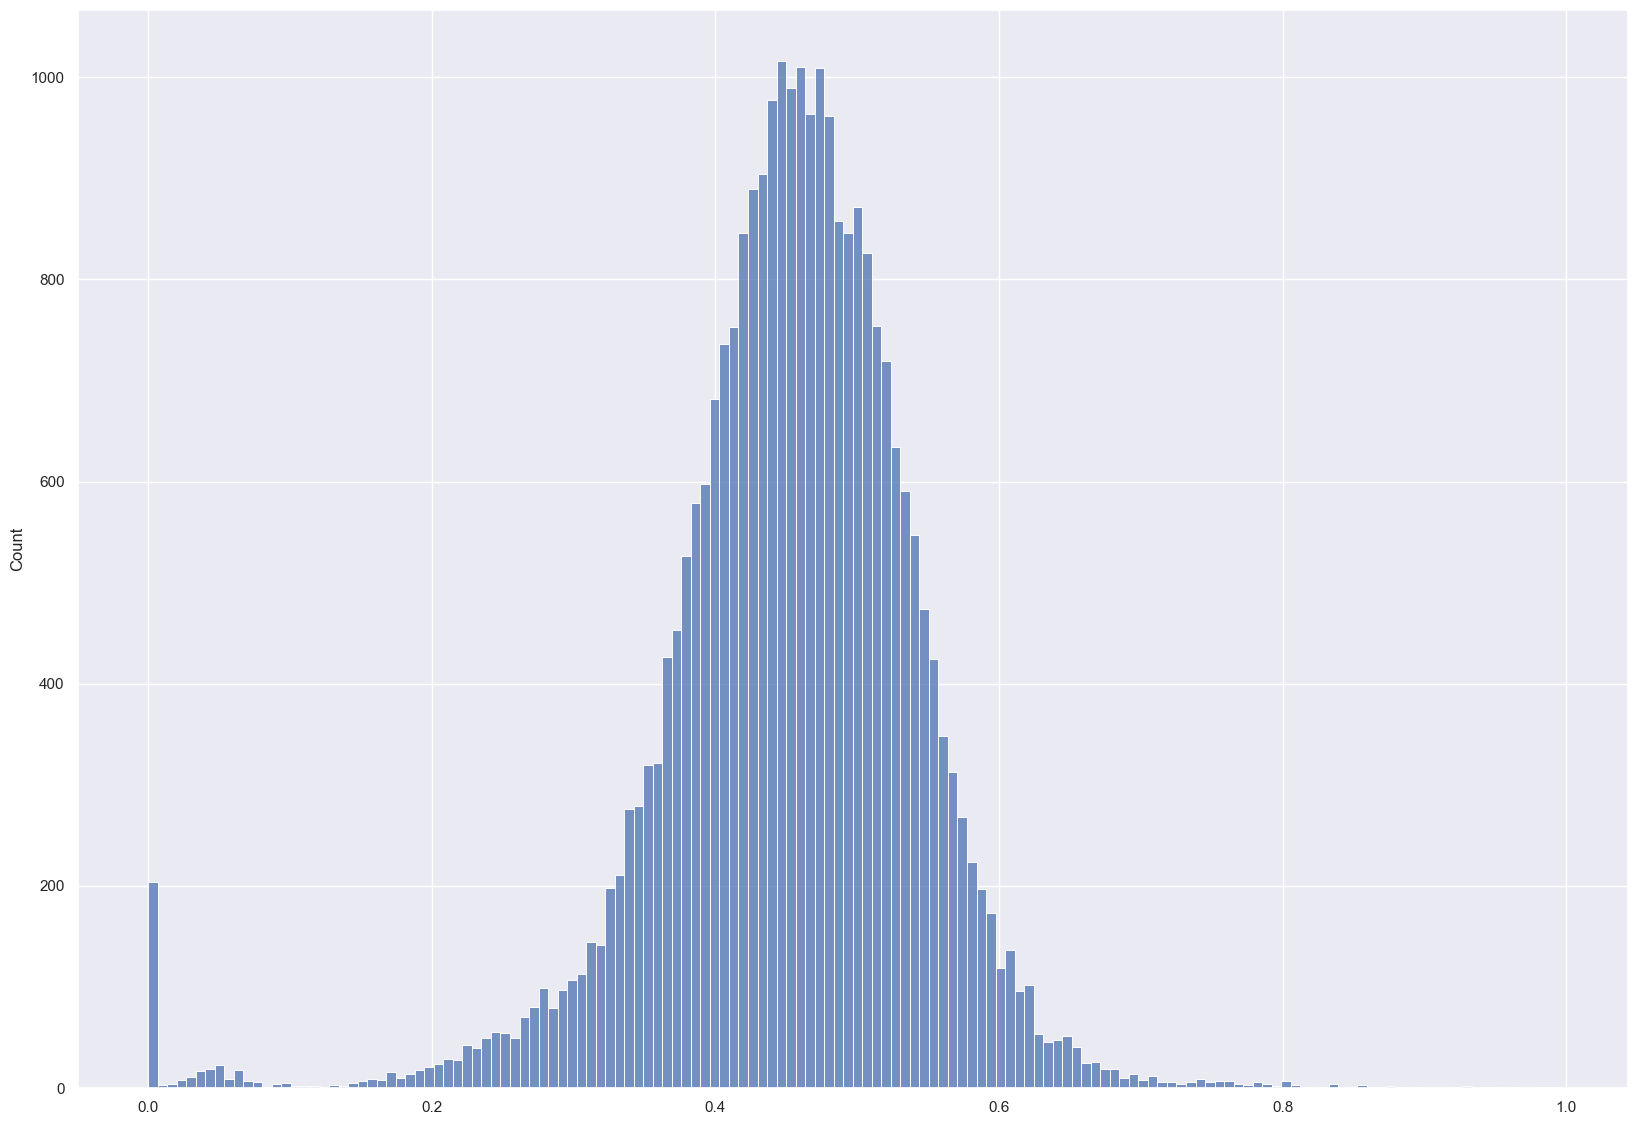

In [15]:
flat_data = [j for sub in Data for j in sub]
sns.histplot(flat_data)

And plot the data:

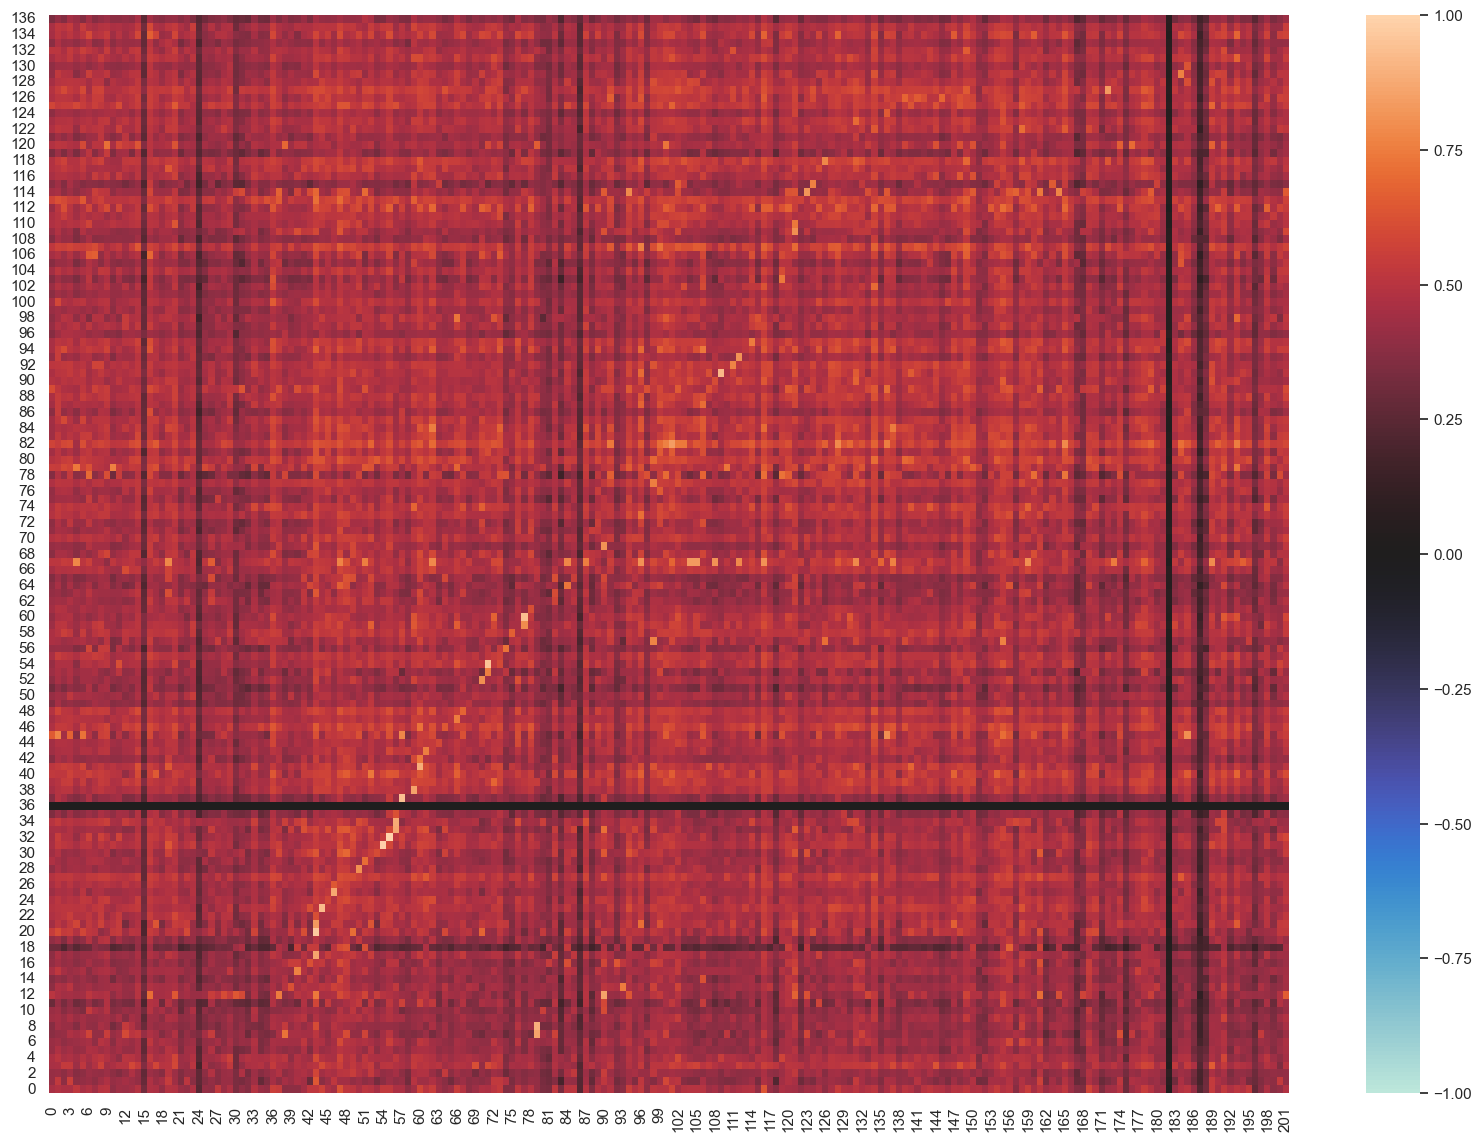

In [16]:
sns.set(rc = {'figure.figsize':(20,14)})
heatmap = sns.heatmap(data=Data, vmin=-1, vmax=1, center=0)
heatmap.invert_yaxis()

As with the previous plot, the x-axis represents the sentences from Melvill's work, and the y-axis represents the sentences from White's text. You can see a greater contrast with the line that runs from the lower left to the upper right.

In [61]:
# Iterate over the _source_ sentences first,
# then find the sentences that are possibly
# plagerisms of that source.
data = numpy.transpose(Data)
preferredWidth=90

for src_index, sus_records in enumerate(data):
    matching_indices = [i for i, r in enumerate(sus_records) if r > 0.79]

    if len(matching_indices) != 0:
        prefix = "Source ["+ str(src_index) + "]: "
        wrapper = textwrap.TextWrapper(initial_indent=prefix, width=preferredWidth, subsequent_indent=' '*len(prefix))
        print(wrapper.fill("%s" % mel_sents[src_index]) + "\n")

        for m in matching_indices:
            inner_prefix = " "*len(prefix) + "Suspect [" + str(m) + "]: "
            wrapper = textwrap.TextWrapper(initial_indent=inner_prefix, width=preferredWidth, subsequent_indent=' '*len(inner_prefix))
            print(wrapper.fill("%s" % egw_sents[m]) + "\n")

Source [43]: Yet so true was St. Paul's assertion, that the weapons of his warfare were
             “mighty through God to the casting down of strong-holds,” that there were men
             of Caesar's household worthy the high title of saints; men not secretly, but
             openly, christians; not ashamed of their professions, but willing to give it
             all publicity by sending greetings to christians in other cities of the
             earth.

             Suspect [17]: Yet in this case, as in so many others, was proved the truth of
                           Paul’s assertion that the weapons of his warfare were “mighty
                           through God to the pulling down of strong holds.”

             Suspect [20]: These were not Christians secretly, but openly.

             Suspect [21]: They were not ashamed of their faith.

Source [44]: And our first inquiry will naturally be, as to the agency which brought round
             so unlikely a result; how it ca

## Final thoughts

### Extending this process
The amount of coding needed to identify the plagerized text above is suprisingly small. However, there are some difficulties with using this method as a general purpose method for identifying all of White's borrowed writing. The majority of these difficulties arise from the volume of data.

In this demonstration, the source of the plagerized texts had already been identified, so the amount of data processed was very small and could be analysed on a laptop in a relatively short amount of time. Sources for some of White's other works have been identified, and there is a record of at least some of the books that White had at her disposal. Even if all those texts were available in Google Books, manually converting them into text files would be impractical. White's work is largely available online and can be retrieved programmatically, but given that some of White's meterials have been altered in later editions, it's unknown if the online materials still all of the plagerized text.

The literature produced by White, and by those from whom she borrowed, date from 1915 at the very latest. As with the text in this demonstration, we expect that the source and borrowed texts contain words that are not supported by spaCy's model. Manually searching for supported synonyms of these unsupported words is not practical for text sizes as large as even a single book. There are libraries that could be used to automate this process, such as [PyDictionary](https://github.com/geekpradd/PyDictionary).





* Computing power needed to compare all the data. Vision - running this on documents in parallel using Cloud servers
* changes in White's material available online vs original publications might further obsscure things.
* running this on the data used for Veltmans's report might be a good candidate for a second small to medium scale attempt. Could even be done on a laptop with sufficient power.